In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# XGBoost Baseline, no NAICS
XGBoost model, but without NAICS features.  Do XGBoost model tuning which will be reused in other scripts.  Also, look at variance in scores

For this baseline only, I run repeated models to get an idea of the variance of metrics

*This script takes about 10 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle, importlib, random

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.inspection import permutation_importance
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot, sg_xgboost

## Import Processed Datasets

In [6]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [7]:
train_df = sba_loans[sba_loans['dset'] == 'train'].copy()
test_df = sba_loans[sba_loans['dset'] == 'test']
val_df = sba_loans[sba_loans['dset'] == 'val']

In [8]:
train_df.shape

(436120, 55)

In [9]:
train_df.drop_duplicates('LoanNr_ChkDgt').shape

(436120, 55)

#### Set the predictor features.  No NAICS-related features at this stage.
Base features only

In [10]:
predictor_features = setup.predictor_features 
print(predictor_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag']


In [11]:
train_df[predictor_features].describe()

,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag
count,436120.000000,436120.000000,432893.000000,4.361200e+05,435584.000000,351624.000000,436120.000000
mean,9.723145,2.164835,0.097777,1.944230e+05,0.281016,0.815075,0.052733
std,61.690596,11.315009,0.297013,2.989452e+05,0.449496,0.388237,0.223501
min,0.000000,0.000000,0.000000,4.000000e+03,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,3.572600e+04,0.000000,1.000000,0.000000
50%,4.000000,0.000000,0.000000,9.000000e+04,0.000000,1.000000,0.000000
75%,9.000000,2.000000,0.000000,2.148528e+05,1.000000,1.000000,0.000000
max,9999.000000,3000.000000,1.000000,1.144632e+07,1.000000,1.000000,1.000000


In [12]:
train_df[predictor_features + ['target']].corr()

,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,target
NoEmp,1.000000,0.062158,-0.013926,0.095658,-0.041427,0.001610,0.006409,-0.027403
CreateJob,0.062158,1.000000,-0.062740,0.134686,0.039302,0.009062,0.050517,-0.010002
LowDoc,-0.013926,-0.062740,1.000000,-0.133141,0.153034,-0.120001,0.040841,-0.079523
DisbursementGross,0.095658,0.134686,-0.133141,1.000000,-0.065443,-0.007016,0.085712,-0.120788
new_business,-0.041427,0.039302,0.153034,-0.065443,1.000000,-0.047592,0.137325,0.013878
urban_flag,0.001610,0.009062,-0.120001,-0.007016,-0.047592,1.000000,-0.006588,0.053785
franchise_flag,0.006409,0.050517,0.040841,0.085712,0.137325,-0.006588,1.000000,-0.012731
target,-0.027403,-0.010002,-0.079523,-0.120788,0.013878,0.053785,-0.012731,1.000000


In [13]:
with open(Path(setup.temp_path).joinpath('03_DATA_features_predict.pkl'), 'wb') as fout:
    pickle.dump(predictor_features, fout)

## Model Hyperparameter Tune and Fit

In [14]:
mean_target = np.mean(train_df['target'])
scale_pos_wt = (1-mean_target)/mean_target
print(f'target rate: {mean_target}, pos wt: {scale_pos_wt}')

target rate: 0.2046546821975603, pos wt: 3.8862796065162346


In [15]:
importlib.reload(sg_xgboost)

<module 'sba_gnn.sba_gnn.sg_xgboost' from '/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code/sba_gnn/sba_gnn/sg_xgboost.py'>

##### Simple hyperparameter search

In [16]:
best_params = sg_xgboost.hyperparameter_tune(train_df[predictor_features], train_df['target'],
                                             pos_wt = scale_pos_wt,
                                             n_estimators = setup.xgb_n_estimators,
                                            random_state = 122234)

In [17]:
print(best_params)

{'subsample': 0.8, 'scale_pos_weight': 1.0, 'reg_lambda': 0.01, 'reg_alpha': 0.001, 'min_child_weight': 50, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 2}


In [18]:
pd.DataFrame({k:[best_params[k]] for k in best_params.keys()}) \
    .to_csv(Path(setup.temp_path).joinpath('03_REPORT_fit_parameter_selected.csv'), index=False)

## Model Fit - Mean and Variance
Do some throwaway runs for metrics

In [19]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

In [20]:
def do_fit_tune():
    this_rand = random.randint(1, 10000)
    """ Fit a model and get metrics with a series of random states"""
    tmp_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators = setup.xgb_n_estimators, 
                            random_state = this_rand)
    tmp_model = tmp_model.set_params(**xgb_params)
    tmp_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])
    tmp_pred = pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   tmp_model.predict_proba(sba_loans[predictor_features])[:,1]})],
                    axis=1) \
        .set_index('index')
    
    # Tune the decision threshold
    tmp_pred_train = tmp_pred[tmp_pred['dset'] == 'train']
    tmp_tune = sg_plot.get_f1_frame(tmp_pred_train['target'], 
                                        tmp_pred_train['predict_prob'])
    
    thresh_head = tmp_tune.sort_values('f1', ascending=False).head(2)
    tmp_best = thresh_head['thresh'].iloc[0]
    
    # Get metrics
    tmp_pred['predict_bin'] = np.where(tmp_pred['predict_prob'] >= tmp_best, 1, 0)
    tmp_metrics = tmp_pred.groupby('dset') \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    tmp_metrics_test = tmp_pred[tmp_pred['dset'] == 'test'] \
        .groupby(['dset', 'dset_naics_holdout']) \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    tmp_metrics['rand'] = this_rand
    tmp_metrics_test['rand'] = this_rand
    return pd.concat([tmp_metrics, tmp_metrics_test])

In [21]:
%%capture
fit_range = range(10)
fit_tune_all = pd.concat([do_fit_tune() for i in fit_range], keys=fit_range) \
    .reset_index(level=0) \
    .rename(columns={'level_0':'run_id'}) \
    .reset_index(drop = True)

In [22]:
fit_tune_all.to_csv(Path(setup.temp_path).joinpath('03_REPORT_fit_variance_raw.csv'), index=False)

In [23]:
fit_tune_mean_sd = fit_tune_all.groupby(['dset', 'dset_naics_holdout']) \
    .agg(['mean', 'std']) \
    .reset_index()

In [24]:
fit_tune_mean_sd

dset dset_naics_holdout run_id          accuracy_score            f1_score  \
                             mean      std           mean       std      mean   
0  test                0.0    4.5  3.02765       0.604190  0.000766  0.433689   
1  test                1.0    4.5  3.02765       0.633795  0.000818  0.423672   

            precision_score           recall_score            \
        std            mean       std         mean       std   
0  0.000316        0.307275  0.000292     0.736820  0.001707   
1  0.000466        0.296682  0.000389     0.740733  0.001906   

  average_precision_score           roc_auc_score              rand  \
                     mean       std          mean       std    mean   
0                0.349297  0.000551      0.704488  0.000126  5557.5   
1                0.352049  0.000455      0.732155  0.000225  5557.5   

                
           std  
0  2033.376188  
1  2033.376188

In [25]:
fit_tune_mean_sd.columns = [' '.join(col).strip() for col in fit_tune_mean_sd.columns.values]

In [26]:
fit_tune_mean_sd.to_csv(Path(setup.temp_path).joinpath('03_REPORT_fit_variance_stats.csv'), index=False)

## Final Fit
Use a random seed

In [27]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators = setup.xgb_n_estimators,
                             random_state=33532)

In [28]:
xgb_model = xgb_model.set_params(**xgb_params)

In [29]:
xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])

[0]	validation_0-logloss:0.50218	validation_1-logloss:0.50551
[1]	validation_0-logloss:0.49608	validation_1-logloss:0.49943
[2]	validation_0-logloss:0.49097	validation_1-logloss:0.49437
[3]	validation_0-logloss:0.48662	validation_1-logloss:0.49009
[4]	validation_0-logloss:0.48298	validation_1-logloss:0.48654
[5]	validation_0-logloss:0.47980	validation_1-logloss:0.48342
[6]	validation_0-logloss:0.47708	validation_1-logloss:0.48078
[7]	validation_0-logloss:0.47480	validation_1-logloss:0.47861
[8]	validation_0-logloss:0.47280	validation_1-logloss:0.47671
[9]	validation_0-logloss:0.47111	validation_1-logloss:0.47510
[10]	validation_0-logloss:0.46969	validation_1-logloss:0.47378
[11]	validation_0-logloss:0.46842	validation_1-logloss:0.47258
[12]	validation_0-logloss:0.46734	validation_1-logloss:0.47158
[13]	validation_0-logloss:0.46640	validation_1-logloss:0.47073
[14]	validation_0-logloss:0.46562	validation_1-logloss:0.47005
[15]	validation_0-logloss:0.46497	validation_1-logloss:0.46946
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, random_state=33532, ...)

In [30]:
train_df['target'].value_counts()

target
0    346866
1     89254
Name: count, dtype: int64

##### Save the model

In [31]:
xgb_model.save_model(Path(setup.temp_path).joinpath('03_MODEL_xgboost.json'))

In [32]:
with open(Path(setup.temp_path).joinpath('03_MODEL_xgboost.pkl'), 'wb') as po:
    pickle.dump(xgb_model, po)

## Probability Predictions

In [33]:
pred_df = pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(sba_loans[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')

In [34]:
pred_df.groupby('target')['predict_prob'].agg(['mean', 'std', 'min', 'max', 'median'])

,mean,std,min,max,median
target,,,,,
0,0.189129,0.106570,0.016819,0.687940,0.190172
1,0.268337,0.092368,0.016819,0.707223,0.283186


## Decision Threshold
Max f1, on training data

In [35]:
pred_train_df = pred_df[pred_df['dset'] == 'train']

In [36]:
thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])

In [37]:
thresh_tune_data.to_csv(Path(setup.temp_path).joinpath('03_REPORT_thresh_tune.csv'), index=False)

In [38]:
thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
best_thresh = thresh_head['thresh'].iloc[0]
print(best_thresh)
thresh_head

0.22


,thresh,f1
11,0.22,0.432929
10,0.20,0.431898


##### Apply decision threshold
All datasets

In [39]:
pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)

In [40]:
pred_df['predict_bin'].value_counts()

predict_bin
0    351299
1    336782
Name: count, dtype: int64

In [41]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('03_DATA_combined_predictions.parquet'))

## Metrics

In [42]:
metrics_dset_df = pred_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('03_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.615897,0.430079,0.303129,0.739982,0.349659,0.716077,NaN
1,train,0.604517,0.432929,0.306368,0.737659,0.352549,0.707118,NaN
2,val,0.602189,0.432300,0.307070,0.730015,0.353011,0.703115,NaN
0,test,0.604045,0.434293,0.307519,0.738907,0.348985,0.704601,0.0
1,test,0.632924,0.423421,0.296276,0.741731,0.351437,0.732046,1.0


## Lift
Test data

In [43]:
pred_test_df = pred_df[pred_df['dset'] == 'test']

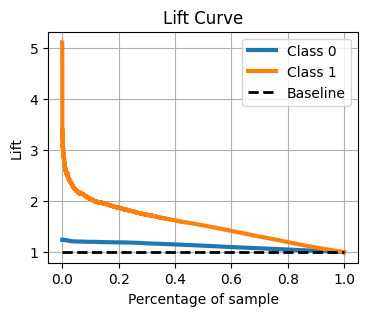

In [44]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('03_PLOT_lift_curve.png'),bbox_inches='tight')

## Feature Importance 

##### XGBoost gain

In [45]:
feat_impgain = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='gain'),
                                     index=['importance']).T \
    .sort_values('importance', ascending=False)

In [46]:
feat_impgain.to_csv(Path(setup.temp_path).joinpath('03_REPORT_importance_gain.csv'), index=True)

In [47]:
feat_impgain.head()

,importance
urban_flag,602.669739
LowDoc,117.842537
DisbursementGross,64.284508
new_business,28.243860
CreateJob,16.816765


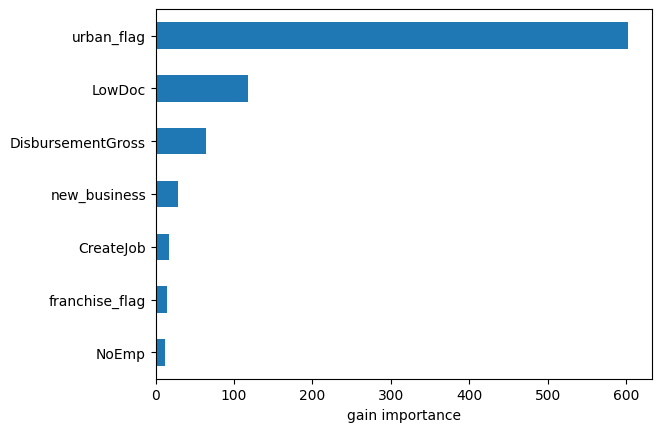

In [48]:
feat_impgain.plot(kind='barh', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('gain importance')
plt.gcf().savefig(Path(setup.temp_path).joinpath('03_PLOT_importance_gain.png'))

##### Permutation Importance

In [49]:
perm_importance = permutation_importance(xgb_model, train_df[predictor_features].reset_index(drop=True), 
                                         train_df['target'].reset_index(drop=True),
                                         n_repeats=30, scoring = 'average_precision')

In [50]:
perm_importance_df = pd.DataFrame({'features':predictor_features,
                                   'importance': perm_importance['importances_mean']}) 
perm_importance_df['abs_importance'] = np.abs(perm_importance_df['importance'])
perm_importance_df = perm_importance_df.sort_values('abs_importance', ascending=False)

In [51]:
perm_importance_df.head(5)

,features,importance,abs_importance
3,DisbursementGross,0.089725,0.089725
5,urban_flag,0.045327,0.045327
1,CreateJob,0.031093,0.031093
2,LowDoc,0.015693,0.015693
0,NoEmp,0.012834,0.012834


In [52]:
perm_importance_df \
    .to_csv(Path(setup.temp_path).joinpath('03_DATA_importance_perturb.csv'),
            index=False)

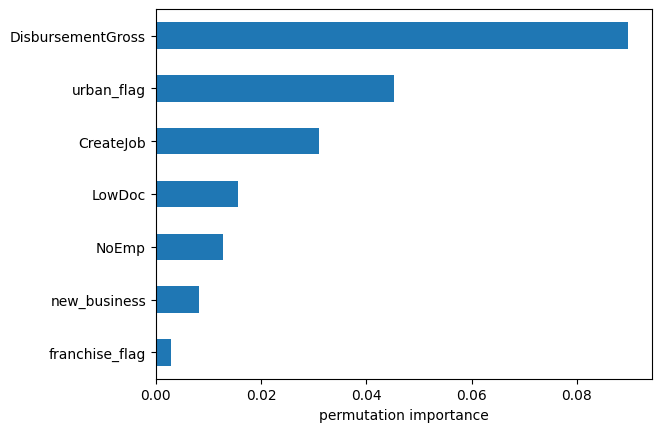

In [53]:
perm_importance_df.head(10).plot(kind='barh', x='features', y='importance', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('permutation importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('03_PLOT_importance_perturb.png'))